# Multi-armed Bandit Problem

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
class MultiArmedBandit:
    def __init__(self, number_of_arms: int) -> None:
        self.number_of_arms = number_of_arms
        self.means = np.random.normal(0, 1, number_of_arms)
        self.optimal_arm = np.argmax(self.means)
        self.optimal_mean = self.means[self.optimal_arm]

    def play(self, arm: int) -> float:
        mean = self.means[arm]
        return np.random.normal(mean, 1)
    


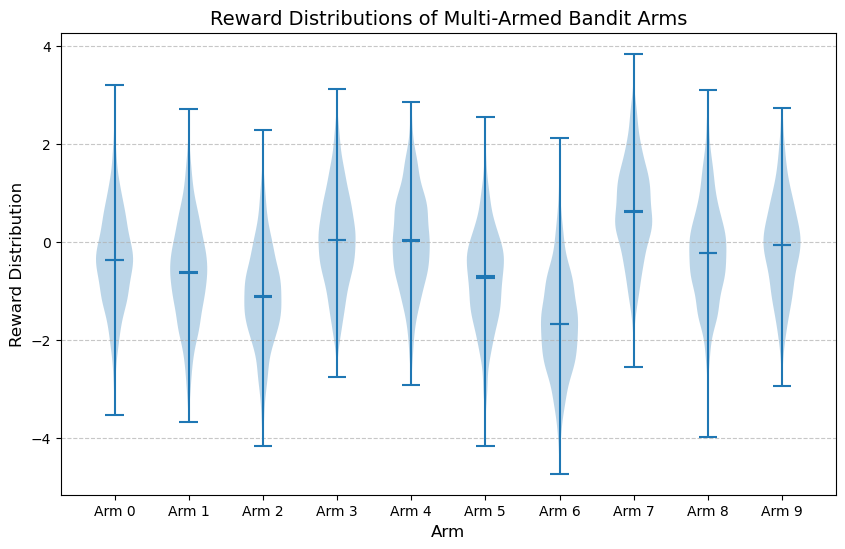

Optimal Arm: 7
Optimal Mean: 0.67


In [3]:
def plot_bandit(bandit: MultiArmedBandit):
    rewards = []
    for arm in range(bandit.number_of_arms):
        simulated_rewards = [bandit.play(arm) for _ in range(1000)] 
        rewards.append(simulated_rewards)
    
    plt.figure(figsize=(10, 6))
    plt.violinplot(rewards, showmeans=True, showmedians=True)
    plt.xlabel("Arm", fontsize=12)
    plt.ylabel("Reward Distribution", fontsize=12)
    plt.title("Reward Distributions of Multi-Armed Bandit Arms", fontsize=14)
    plt.xticks(range(1, bandit.number_of_arms + 1), [f'Arm {i}' for i in range(bandit.number_of_arms)], fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

bandit = MultiArmedBandit(10)
plot_bandit(bandit)
print(f"Optimal Arm: {bandit.optimal_arm}")
print(f"Optimal Mean: {bandit.optimal_mean:.2f}")

In [4]:
# random agent for a baseline
class RandomAgent:
    def __init__(self, bandit: MultiArmedBandit) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms

    def choose_action(self) -> int:
        return np.random.randint(0, self.number_of_arms)
    
    def update(self, arm: int, reward: float) -> None:
        pass
    

In [5]:
def run_and_collect_data(agent, bandit, num_steps):
    rewards = []
    best_action_counts = []
    regrets = []
    for _ in range(num_steps):
        action = agent.choose_action()
        reward = bandit.play(action)
        agent.update(action, reward)
        rewards.append(reward)
        best_action_counts.append(action == bandit.optimal_arm)
        regrets.append(bandit.optimal_mean - bandit.means[action])
    return rewards, best_action_counts, regrets


In [6]:
def run_and_plot_for_agents(agents, agent_names, bandit, num_steps):
    all_rewards = []
    all_best_action_counts = []
    all_regrets = []

    for agent in agents:
        rewards, best_action_counts, regrets = run_and_collect_data(agent, bandit, num_steps)
        all_rewards.append(rewards)
        all_best_action_counts.append(best_action_counts)
        all_regrets.append(regrets)
    
    average_rewards = [np.cumsum(rewards) / (np.arange(len(rewards)) + 1) for rewards in all_rewards]
    average_best_action_counts = [np.cumsum(best_action_counts) / (np.arange(len(best_action_counts)) + 1) for best_action_counts in all_best_action_counts]
    cumulative_regrets = [np.cumsum(regrets) for regrets in all_regrets]
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 12))
    
    for i, (agent, name) in enumerate(zip(agents, agent_names)):
        ax[0].plot(average_rewards[i], label=f'{name}')
        ax[1].plot(average_best_action_counts[i], label=f'{name}')
        ax[2].plot(cumulative_regrets[i], label=f'{name}')
    
    ax[0].set_xlabel('Steps', fontsize=12)
    ax[0].set_ylabel('Average Reward', fontsize=12)
    ax[0].set_title('Average Reward vs Steps', fontsize=14)
    ax[0].grid(linestyle='--', alpha=0.7)
    ax[0].legend()

    ax[1].set_xlabel('Steps', fontsize=12)
    ax[1].set_ylabel('Best Action Count', fontsize=12)
    ax[1].set_title('Best Action Count vs Steps', fontsize=14)
    ax[1].grid(linestyle='--', alpha=0.7)
    ax[1].legend()

    ax[2].set_xlabel('Steps', fontsize=12)
    ax[2].set_ylabel('Regret', fontsize=12)
    ax[2].set_title('Regret vs Steps', fontsize=14)
    ax[2].grid(linestyle='--', alpha=0.7)
    ax[2].legend()

    plt.tight_layout()
    plt.show()


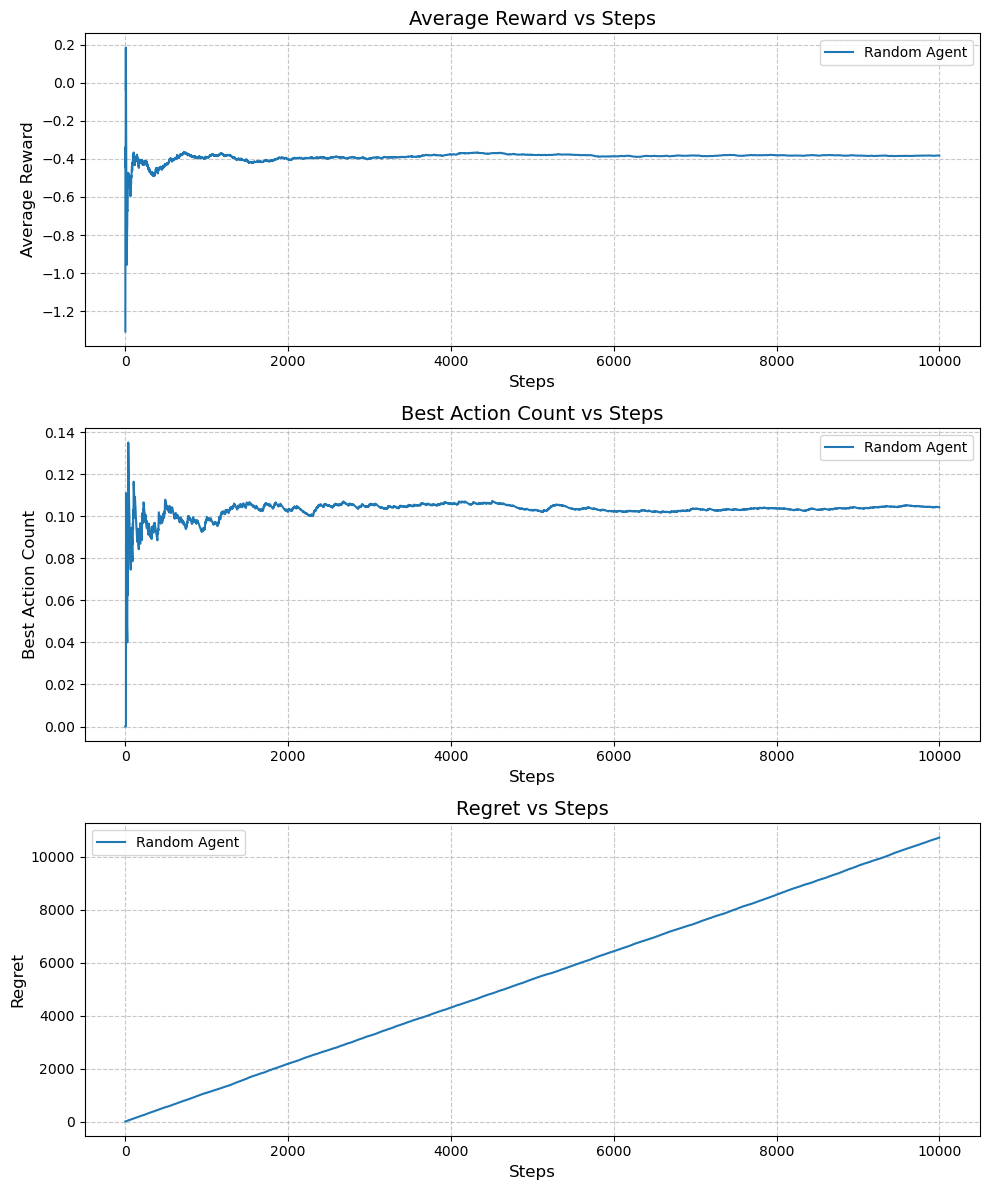

In [7]:
random_agent = RandomAgent(bandit)
agents = [random_agent]
agent_names = ['Random Agent']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

In [8]:
# a agent that explore every arm N times and then exploit the best arm
class ExploreThenExploit:
    def __init__(self, bandit: MultiArmedBandit, N: int) -> None:
        self.bandit = bandit
        self.N = N 
        self.number_of_arms = bandit.number_of_arms
        self.countAction = [0] * self.number_of_arms
        self.arm_rewards = [0.0] * self.number_of_arms
        self.optimal_arm = 0 

    def choose_action(self) -> int:
        for arm in range(self.number_of_arms):
            if self.countAction[arm] < self.N:
                self.countAction[arm] += 1
                return arm
        self.optimal_arm = self.arm_rewards.index(max(self.arm_rewards))
        return self.optimal_arm
        
    def update(self, arm: int, reward: float) -> None:
        self.countAction[arm]+=1
        self.arm_rewards[arm] += (reward - self.arm_rewards[arm]) / self.countAction[arm]



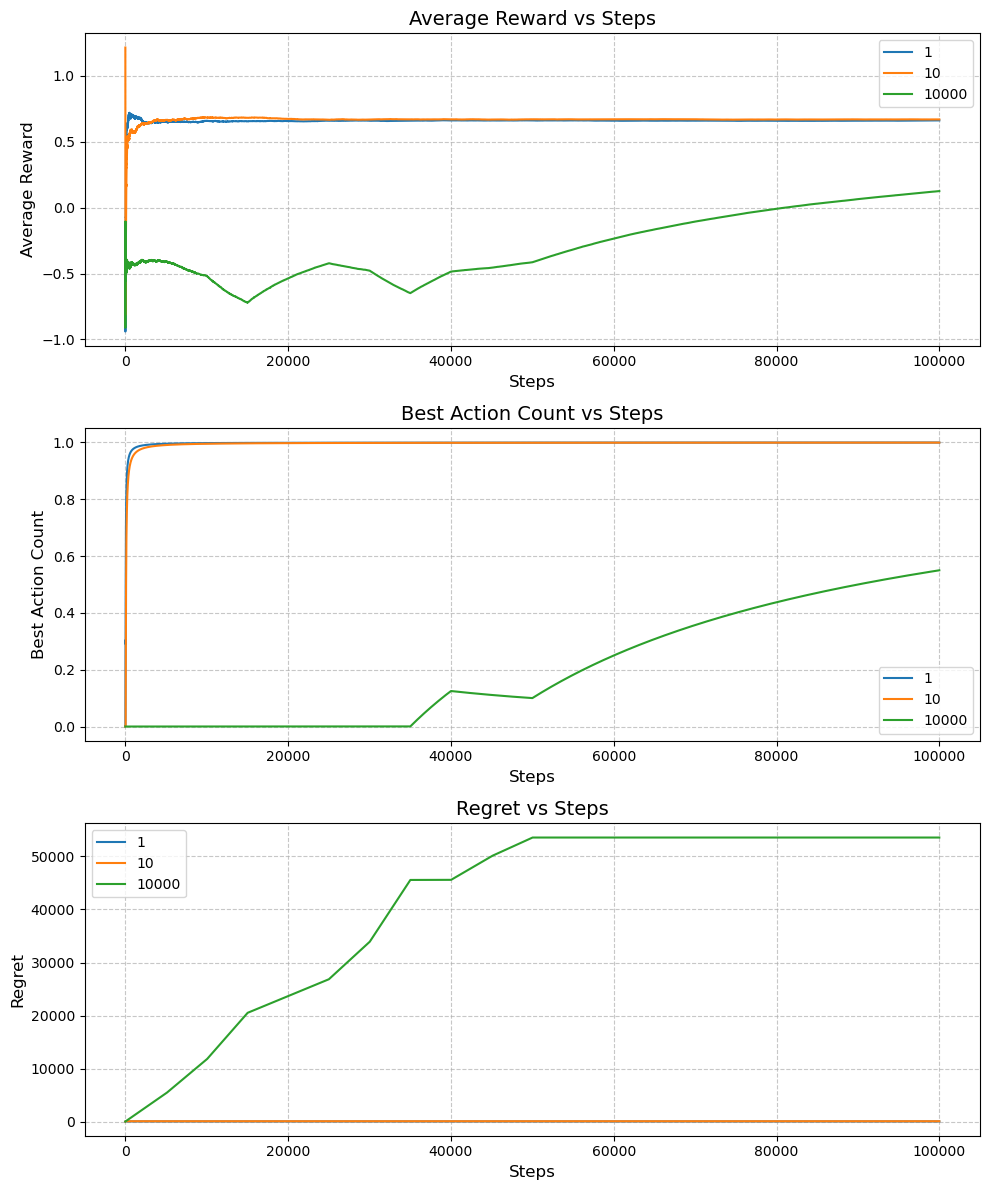

In [9]:
# TODO: run ExploreThenExploit agent for different values of N and comment on the results

explore_then_exploit_1 = ExploreThenExploit(bandit,1)
explore_then_exploit_10 = ExploreThenExploit(bandit,10)
explore_then_exploit_10000 = ExploreThenExploit(bandit,10000)
agents = [explore_then_exploit_1, explore_then_exploit_10, explore_then_exploit_10000]
agent_names = ['1', '10', '10000']
run_and_plot_for_agents(agents, agent_names, bandit, 100000)

In [10]:
class EpsilonGreedy:
    def __init__(self, bandit: MultiArmedBandit, epsilon: float=0.1) -> None:
        self.bandit = bandit
        self.epsilon = epsilon 
        self.number_of_arms = bandit.number_of_arms
        self.countAction = [0] * self.number_of_arms
        self.arm_rewards = [0.0] * self.number_of_arms
        self.optimal_arm = 0 

    def choose_action(self) -> int:
        proba_explore = np.random.rand(0, 1)
        if proba_explore<=self.epsilon: 
            greedy_choose = np.random.randint(0, self.number_of_arms)
            return greedy_choose
            
        self.optimal_arm = self.arm_rewards.index(max(self.arm_rewards))
        return self.optimal_arm

    def update(self, arm: int, reward: float) -> None:
        self.countAction[arm]+=1
        self.arm_rewards[arm] += 1.0 /self.countAction[arm]  * (reward - self.arm_rewards[arm])
        

/var/folders/5g/lb5rqdn537gdsvb2ylrqtblm0000gn/T/ipykernel_14445/2497251228.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if proba_explore<=self.epsilon:


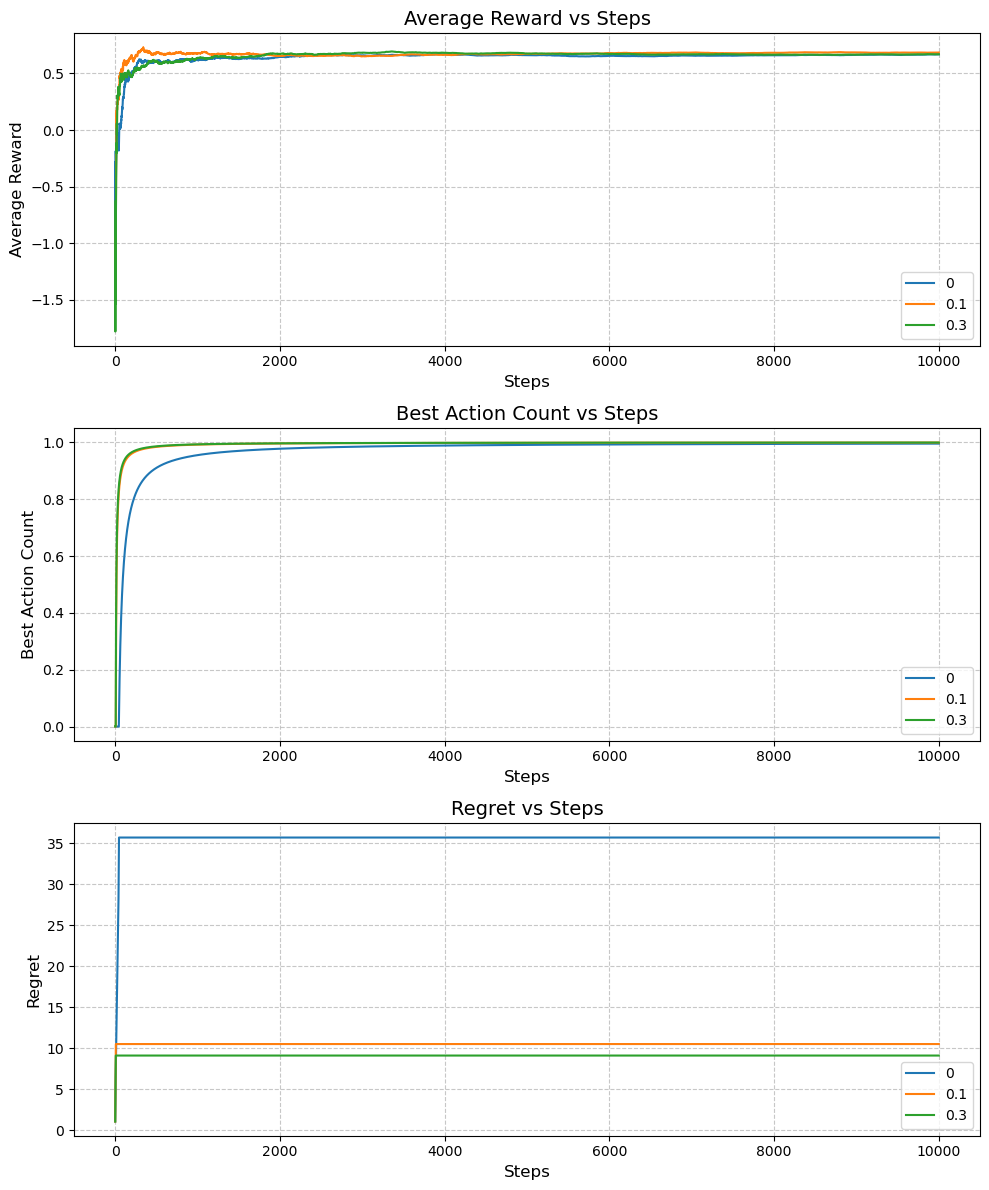

In [11]:
# TODO: Run the epsilon-greedy agent for different values of N and comment on the results

EpsilonGreedy_O = EpsilonGreedy(bandit,0)
EpsilonGreedy_01 = EpsilonGreedy(bandit,0.1)
EpsilonGreedy_03 = EpsilonGreedy(bandit,0.3)
agents = [EpsilonGreedy_O, EpsilonGreedy_01, EpsilonGreedy_03]
agent_names = ['0', '0.1', '0.3']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

In [12]:
class UCB:
    def __init__(self, bandit: MultiArmedBandit, c: float = 2) -> None:
        self.bandit = bandit
        self.c = c
        self.number_of_arms = bandit.number_of_arms
        self.countAction = [0] * self.number_of_arms
        self.arm_rewards = [0.0] * self.number_of_arms
        self.UCB = [float('inf')] * self.number_of_arms 
        self.optimal_arm = 0

    def choose_action(self) -> int:
        arm_choose = np.argmax(self.UCB)
        return arm_choose

    def update(self, arm: int, reward: float) -> None:
        self.countAction[arm] += 1
        self.arm_rewards[arm] += (1.0 / self.countAction[arm]) * (reward - self.arm_rewards[arm])
        
        self.UCB[arm] = self.arm_rewards[arm] + self.c * np.sqrt(np.log(np.sum(self.countAction)) / self.countAction[arm])
                    
        

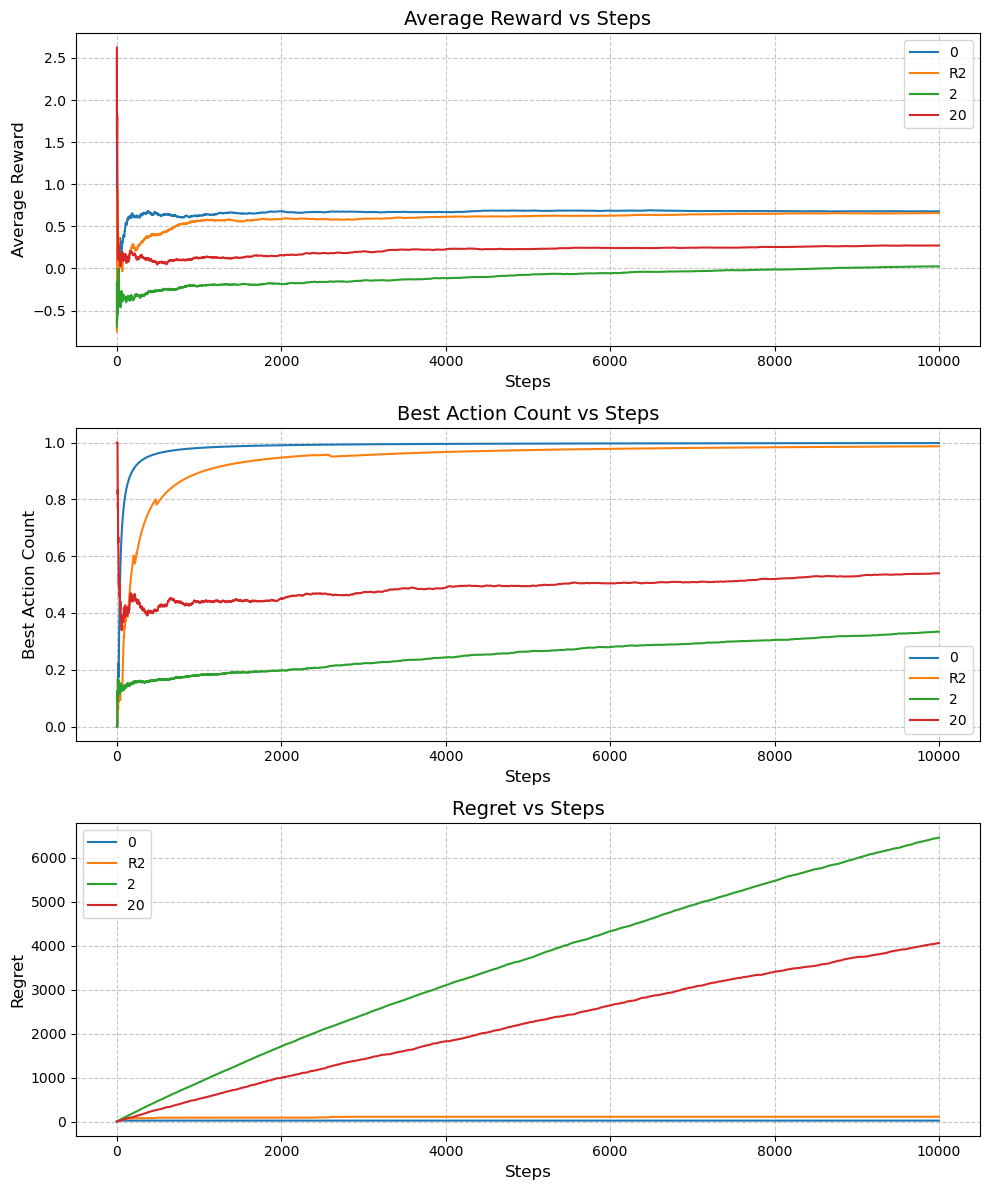

In [13]:
# TODO: Run the UCB agent for different values of c and comment on the results

UCB_0 = UCB(bandit,0)
UCB_R2 = UCB(bandit,np.sqrt(2))
UCB_2 = UCB(bandit,2)
UCB_2 = UCB(bandit,20)
agents = [UCB_0, UCB_R2, UCB_2, UCB_2]
agent_names = ['0', 'R2', '2', '20']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

/var/folders/5g/lb5rqdn537gdsvb2ylrqtblm0000gn/T/ipykernel_14445/2497251228.py:12: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if proba_explore<=self.epsilon:


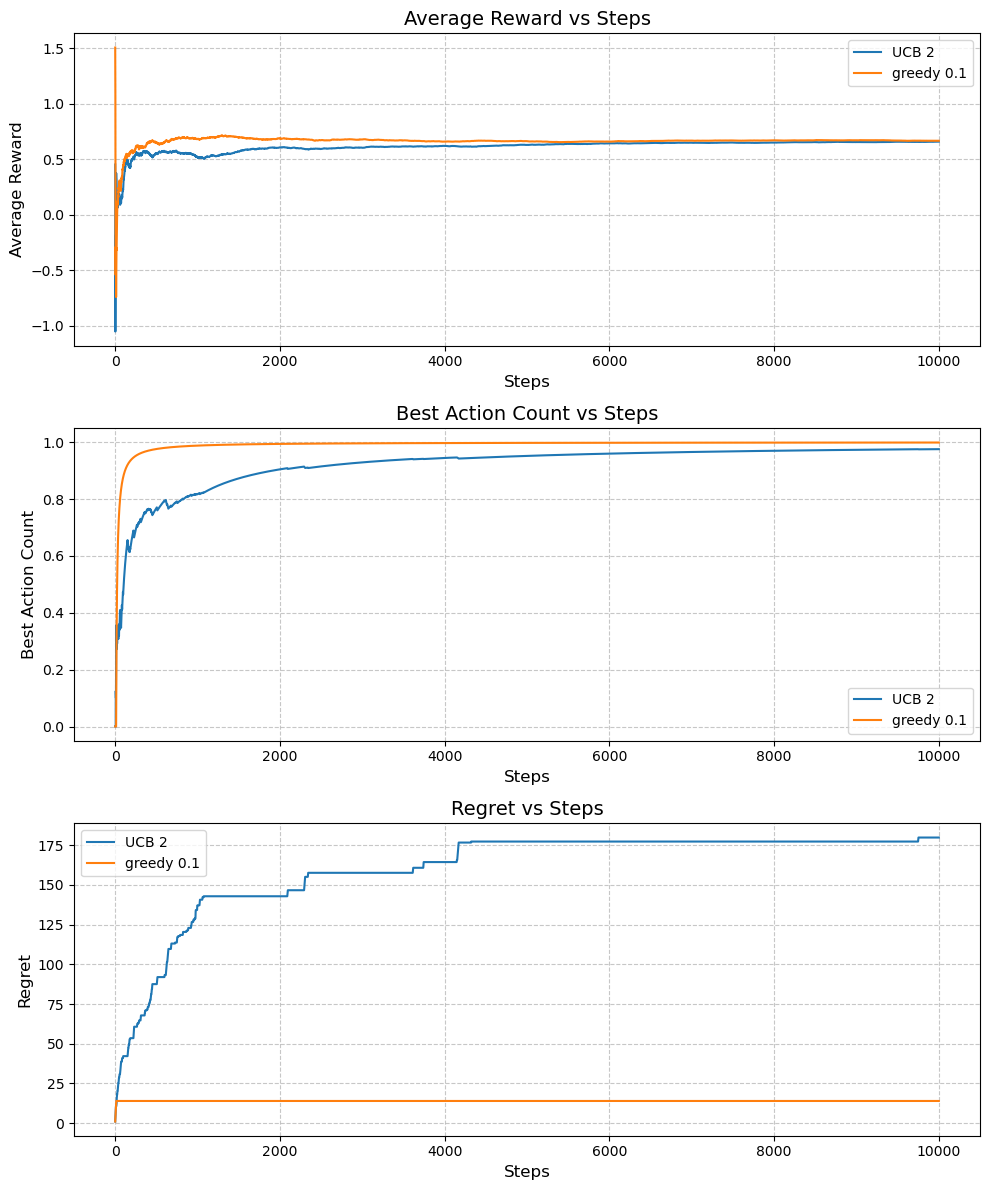

In [14]:
# TODO: run the epsilon greedy and UCB agents; compare the results

UCB_2 = UCB(bandit,2)
EpsilonGreedy_01 = EpsilonGreedy(bandit,0.1)
agents = [UCB_2, EpsilonGreedy_01]
agent_names = ['UCB 2', 'greedy 0.1']
run_and_plot_for_agents(agents, agent_names, bandit, 10000)

In [16]:
# TODO: Create a new class MultiArmedBanditBernoulli that generates rewards from a Bernoulli distribution
class MultiArmedBanditBernoulli:
    def __init__(self, number_of_arms: int) -> None:
        self.number_of_arms = number_of_arms
        self.means = np.random.uniform(0, 1, number_of_arms)
        self.optimal_arm = np.argmax(self.means)
        self.optimal_mean = self.means[self.optimal_arm]
        
        self.arm_alpha = [0.0] * self.number_of_arms
        self.arm_beta = [0.0] * self.number_of_arms
        self.arm_rewards = [0.0] * self.number_of_arms

    def play(self, arm: int) -> float:
        for arm in range (self.number_of_arms):
            self.arm_rewards[arm] = np.random.beta(alpha+1, beta+1)
        return np.argmax(self.arm_rewards)
    
      if reward == 1:
            self.arm_alpha[arm] += 1  # Incrémenter alpha en cas de succès
        else:
            self.arm_beta[arm] += 1   # Incrémenter beta en cas d'échec
            
            


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 18)

In [17]:
# TODO: Implement the Thompson Sampling algorithm

class ThompsonSampling:
    def __init__(self, bandit: MultiArmedBandit) -> None:
        self.bandit = bandit
        self.number_of_arms = bandit.number_of_arms
        self.alpha = np.ones(self.number_of_arms)
        self.beta = np.ones(self.number_of_arms)
        
        self.arm_rewards = [0.0] * self.number_of_arms

    def choose_action(self) -> int:
        for arm in range (self.number_of_arms):
            self.arm_rewards[arm] = np.random.beta(self.alpha[arm], self.beta[arm])
        return np.argmax(self.arm_rewards)

    def update(self, action: int, reward: float) -> None:
        if reward == 1:
            self.alpha[action] += 1
        else:
            self.beta[action] += 1

    def plot_beta_distribution(self, arms= None):
        '''Plot the beta distribution of the arms'''
        if arms is None:
            arms = range(self.number_of_arms)
        x = np.linspace(0, 1, 1000)
        for i in arms:
            y = np.exp(np.log(x) * (self.alpha[i] - 1) + np.log(1 - x) * (self.beta[i] - 1))
            plt.plot(x, y, label=f'Arm {i}')
        plt.xlabel('p')
        plt.ylabel('Density')
        plt.title('Beta Distribution for Each Arm')
        plt.legend()
        plt.show()

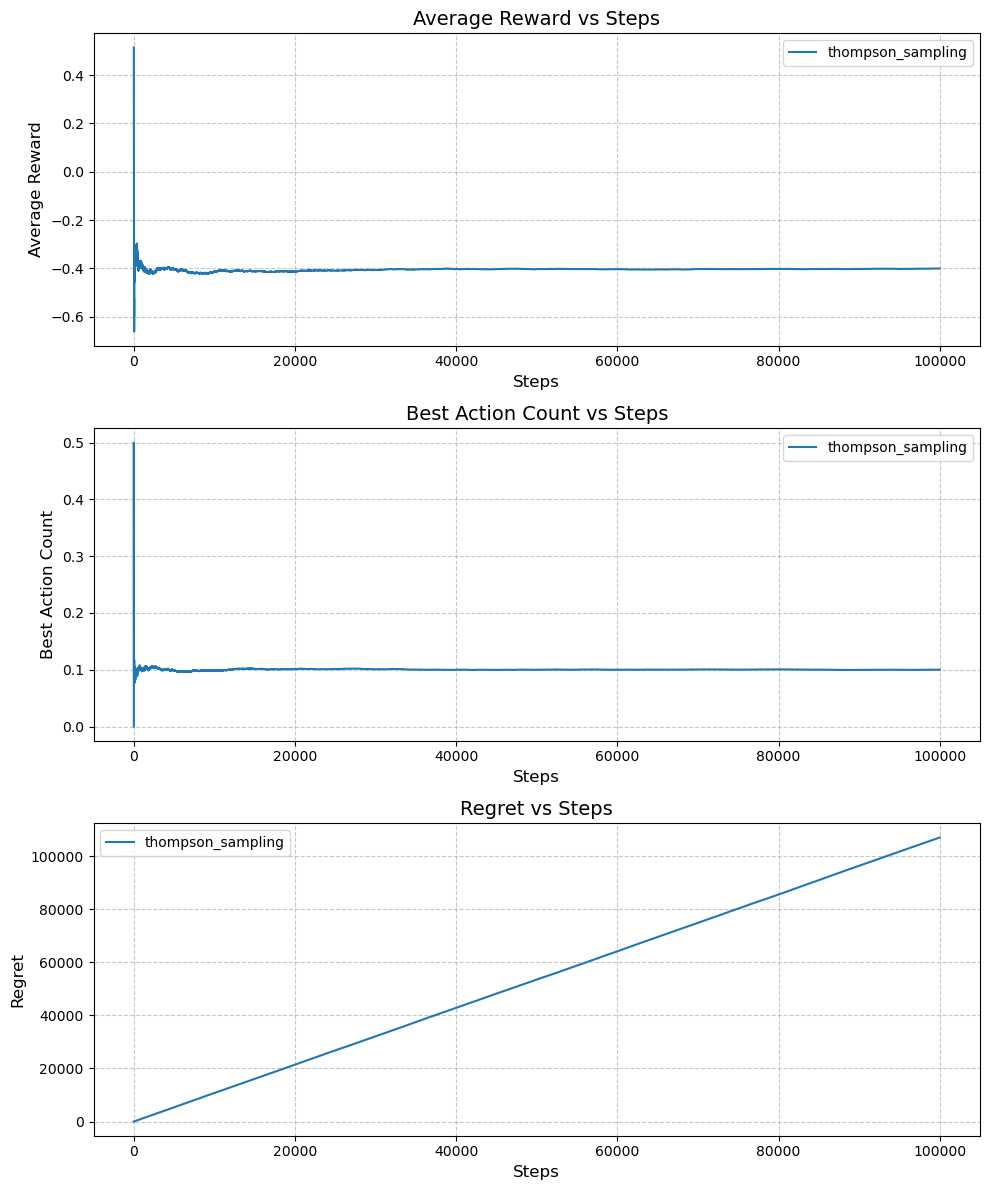

In [19]:
# TODO: run the Thompson Sampling agent and compare the results with other agents. Plot the beta distributions at the end of the learning process.

thompson_sampling = ThompsonSampling(bandit)

agents = [thompson_sampling]
agent_names = ['thompson_sampling']

run_and_plot_for_agents(agents, agent_names, bandit, 100000)




/var/folders/5g/lb5rqdn537gdsvb2ylrqtblm0000gn/T/ipykernel_14445/2018115809.py:29: RuntimeWarning: divide by zero encountered in log
  y = np.exp(np.log(x) * (self.alpha[i] - 1) + np.log(1 - x) * (self.beta[i] - 1))
/var/folders/5g/lb5rqdn537gdsvb2ylrqtblm0000gn/T/ipykernel_14445/2018115809.py:29: RuntimeWarning: invalid value encountered in multiply
  y = np.exp(np.log(x) * (self.alpha[i] - 1) + np.log(1 - x) * (self.beta[i] - 1))


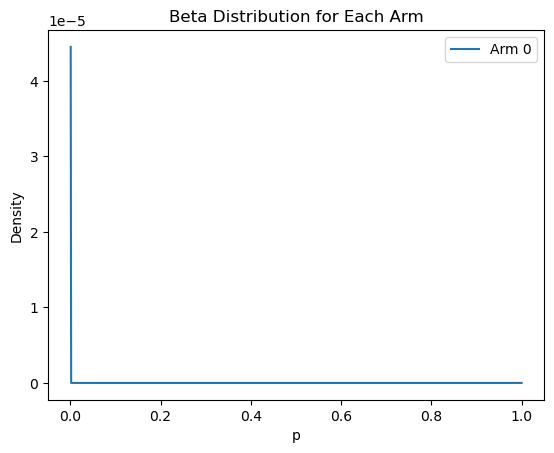

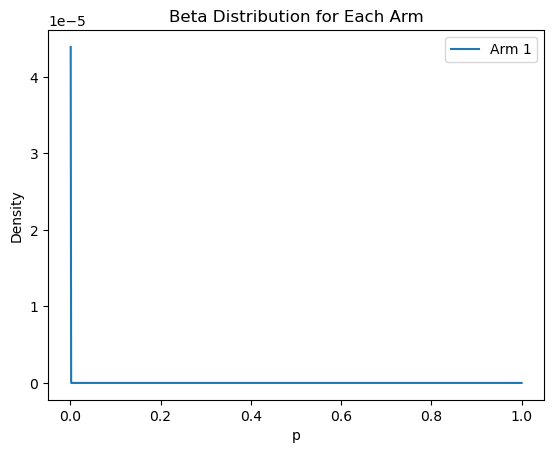

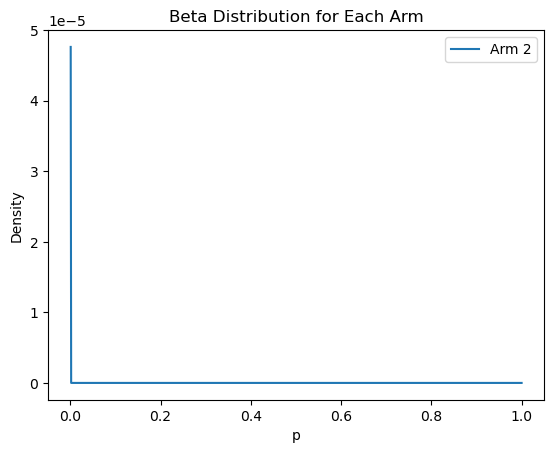

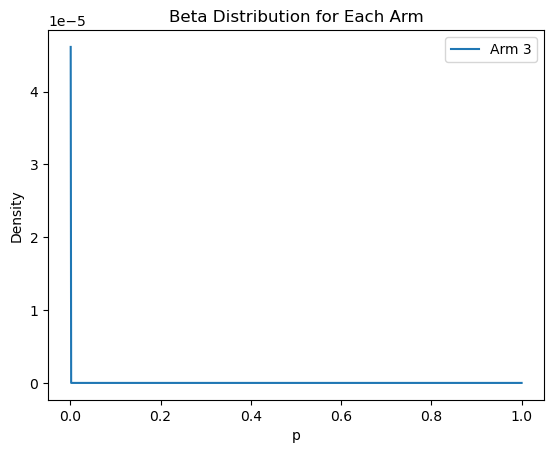

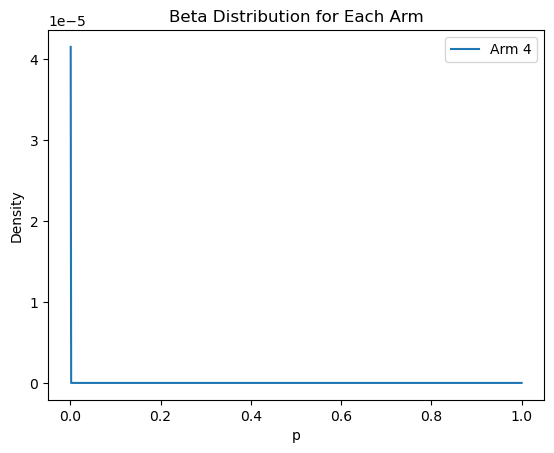

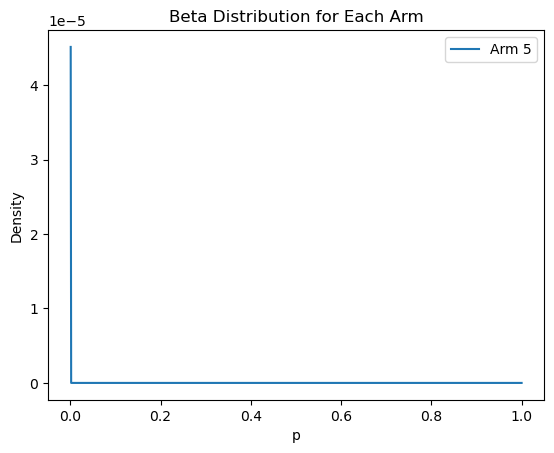

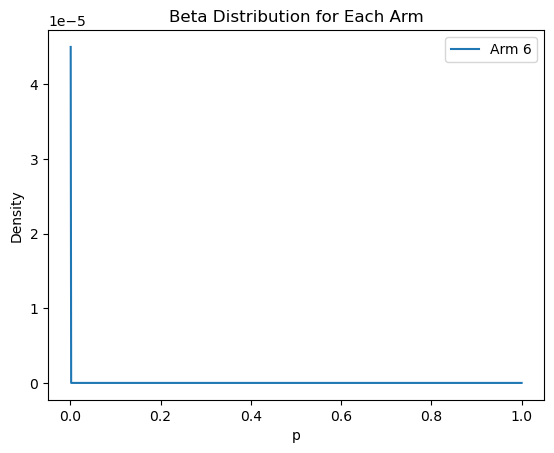

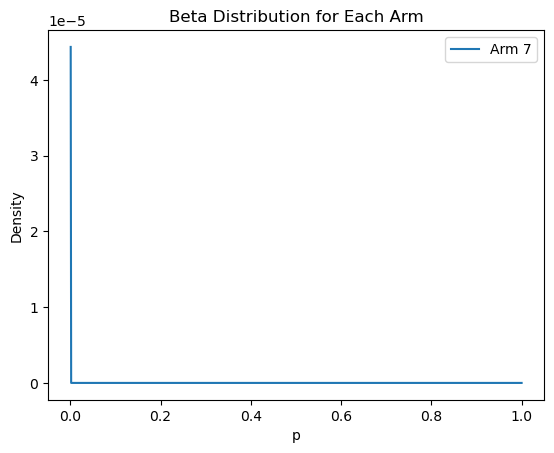

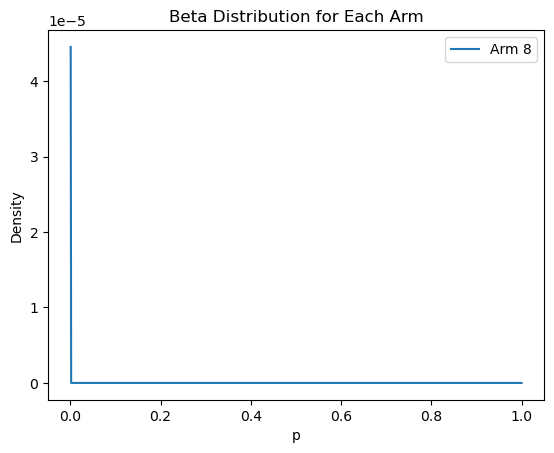

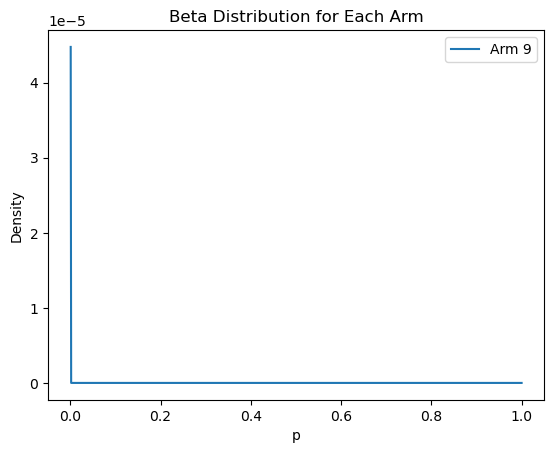

In [20]:
for arm in range (bandit.number_of_arms):
    thompson_sampling.plot_beta_distribution(arms = [arm])
